# Deep Penguin Classification

In [2]:
#| code-fold: true

import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

target_ix_dict = {
  "Adelie Penguin (Pygoscelis adeliae)" : 0,
  "Chinstrap penguin (Pygoscelis antarctica)" : 1,
  "Gentoo penguin (Pygoscelis papua)" : 2
}

class PenguinsDataset(Dataset):
  def __init__(self, train = True):
    if train: 
      url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
    else:
      url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"

    df = pd.read_csv(url)
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = pd.get_dummies(df, columns = [
      "Island", "Stage", "Clutch Completion", "Sex"
    ])
    df = df.dropna()

    self.df = df
    self.transform = lambda x: torch.tensor(x, dtype = torch.float32)
    self.target_ix = lambda x: target_ix_dict[x]
    self.target_transform = lambda x: torch.zeros(
    3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(x), value=1)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    features = self.df.drop(["Species"], axis = 1).iloc[idx,:]
    label    = self.df.iloc[idx,:]["Species"]
    features = self.transform(features)
    
    label    = self.target_ix(label)
    label    = self.target_transform(label)

    features = features.to(device)
    label = label.to(device)

    return features, label

In [4]:
#| code-fold: true

if torch.backends.mps.is_available():
  device = "cpu"
elif torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

Here are our data sets. `PenguinsDataset` is a custom class that I implemented above, while `DataLoader` is a utility from `torch` that automatically handles things like batching and randomization for gradient descent. 

In [5]:
train = PenguinsDataset()
train_dataloader = DataLoader(train, batch_size=10, shuffle=True)

val = PenguinsDataset(False)
val_dataloader = DataLoader(val, batch_size=10, shuffle=True)

Now we're ready to define our model. To see how we do things in torch, let's start by implementing logistic regression. To start, we need to create a predictor model that does the prediction step of logistic regression. If you'll recall, this is nothing more than matrix multiplication. The `nn.Linear` "layer" supplied by `torch` implements this: 

In [6]:
from torch import nn

class penguinLogistic(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Sequential(
      nn.Linear(14, 3) # (number of features, number of class labels)
    )
  def forward(self, x):
    return self.linear(x)

We can optimize this model using the cross-entropy loss and the Adam optimizer. As you'll recall, logistic regression is nothing more than matrix multiplication plus the cross-entropy loss, so this is a logistic regression model! 

In [7]:
model = penguinLogistic()
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now we need to actually perform the optimization. The `torch` package gives us a lot of control over exactly how this happens, and we'll go over the details in a future lecture. 

In [8]:
#| code-fold: true

def training_loop(model, train_dataloader, val_dataloader, learning_rate, epochs):

  train_size = len(train_dataloader.dataset)
  val_size = len(val_dataloader.dataset)

  train_loss_history = []
  train_acc_history  = []
  val_loss_history   = []
  val_acc_history    = []

  for t in range(epochs):
    train_loss = 0.0
    train_acc  = 0.0
    val_loss   = 0.0
    val_acc    = 0.0

    for batch, (X, y) in enumerate(train_dataloader):
      
      optimizer.zero_grad()
      pred = model(X)
      fit = loss_fn(pred, y)
      train_loss += fit.item() / train_size
      
      train_acc += (pred.argmax(dim = 1) == y.argmax(dim = 1)).sum() / train_size
      
      # Backpropagation
      
      fit.backward()
      optimizer.step()

    train_loss_history += [train_loss]
    train_acc_history  += [train_acc]

    for batch, (X, y) in enumerate(val_dataloader):
      with torch.no_grad():
        pred = model(X)
        fit = loss_fn(pred, y)
        val_loss += fit.item() / val_size
        val_acc += (pred.argmax(dim = 1) == y.argmax(dim = 1)).sum() / val_size

    val_loss_history += [val_loss]
    val_acc_history  += [val_acc]

    if t % 50 == 0:
      print(f"epoch {t}: val_loss = {val_loss}, val_accuracy = {val_acc}")
    
  return train_loss_history, train_acc_history, val_loss_history, val_acc_history


from matplotlib import pyplot as plt

def plot_histories(tlh, tah, vlh, vah):

  fig, axarr = plt.subplots(1, 2, figsize = (6, 3))

  axarr[0].plot(tlh, label = "train")
  axarr[0].plot(vlh, label = "validation")
  axarr[0].legend()
  axarr[0].set(xlabel = "epoch", title = "loss")
  axarr[0].semilogy()

  axarr[1].plot(tah, label = "train")
  axarr[1].plot(vah, label = "validation")
  axarr[1].legend()
  axarr[1].set(xlabel = "epoch", title = "accuracy")

Let's go ahead and train! 

epoch 0: val_loss = 5.624737823710722, val_accuracy = 0.3382353186607361
epoch 50: val_loss = 0.2299227907377131, val_accuracy = 0.38235294818878174
epoch 100: val_loss = 0.1359223749707727, val_accuracy = 0.5147058963775635
epoch 150: val_loss = 0.09175908959963744, val_accuracy = 0.6029412150382996
epoch 200: val_loss = 0.06135511223007652, val_accuracy = 0.7500000596046448
epoch 250: val_loss = 0.050761135185466086, val_accuracy = 0.75
epoch 300: val_loss = 0.04315454644315383, val_accuracy = 0.8382353186607361
epoch 350: val_loss = 0.03966436578946955, val_accuracy = 0.8529411554336548
epoch 400: val_loss = 0.029550061725518283, val_accuracy = 0.9411765336990356
epoch 450: val_loss = 0.024872612865532145, val_accuracy = 0.9411765336990356


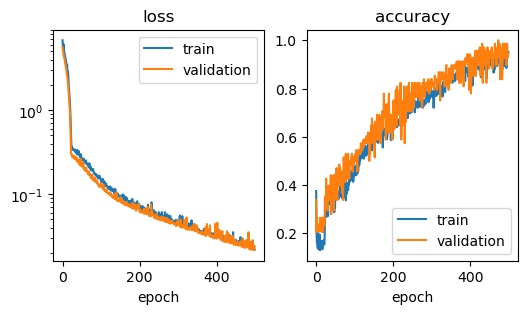

In [9]:
tlh, tah, vlh, vah = training_loop(model, train_dataloader, val_dataloader, 1e-4, 500)
plot_histories(tlh, tah, vlh, vah)

We can see that our model is doing much better than we would expect from random guessing on this problem, although it may not be competitive with many of the models that you implemented in your analysis of the penguins data set. Further training or tweaks to parameters like batch sizes and learning rates could potentially help improve performance here. 

Let's try adding a hidden layer, as in @eq-single-layer. To do this, we need to add a nonlinearity $\alpha$ and more `Linear` layers. The important points are: 

1. The first dimension of the first linear layer needs to match the number of features of the input. 
2. The final dimension of the last linear layer needs to match the number of possible labels. 
3. The final dimension of each linear layer needs to match the first dimension of the next layer. 

These rules follow directly from the need to make all the matrix multiplications turn out right. 

So, let's try a model with a single layer of 100 hidden units: 

In [10]:
from torch import nn
class penguinNN(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.linear_relu_stack = nn.Sequential(
          nn.Linear(14, 100), # U_1
          nn.ReLU(),          # common choice of alpha these days
          nn.Linear(100, 3)   # W
      )

  def forward(self, x):
    return self.linear_relu_stack(x)

model = penguinNN().to(device)

We can optimize it using the same approach as before: 

epoch 0: val_loss = 10.76734447479248, val_accuracy = 0.4852941036224365
epoch 50: val_loss = 0.0789748820311883, val_accuracy = 0.6470587849617004
epoch 100: val_loss = 0.0914852855836644, val_accuracy = 0.6176470518112183
epoch 150: val_loss = 0.042512568480828225, val_accuracy = 0.8823529481887817
epoch 200: val_loss = 0.041880780283142544, val_accuracy = 0.8970588445663452
epoch 250: val_loss = 0.04079361150369924, val_accuracy = 0.8529411554336548
epoch 300: val_loss = 0.06874325433198143, val_accuracy = 0.6323530077934265
epoch 350: val_loss = 0.03214393775252735, val_accuracy = 0.8529411554336548
epoch 400: val_loss = 0.02306258481215028, val_accuracy = 0.8970588445663452
epoch 450: val_loss = 0.013708957306602423, val_accuracy = 0.9705883264541626


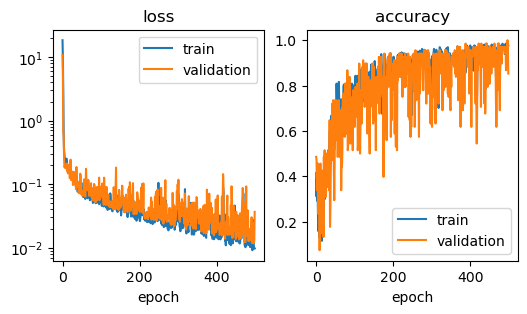

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

tlh, tah, vlh, vah = training_loop(model, train_dataloader, val_dataloader, 1e-4, 500)
plot_histories(tlh, tah, vlh, vah)

This model has also done well on this task, although still not closer to perfect accuracy. It's also interesting to note that the model's loss and accuracy both vary quite wildly during the training process. This is not uncommon, but may also point to a possible benefit of using a smaller step-size. 

It might appear that we haven't really gained much from the massive costs of mathematical structure and computational architecture -- we could have done better with just tools from `sklearn`, or even our own hand-built implementations! We'll soon see the infrastructure working to our advantage when we get to problems involving large data sets with complex structure, like text and images. 
